# Algerian Forest Fires

---

In this project, I examine the forests dataset that includes variables on weather and fire risk for locations in Algerian forests from two different regions. By plotting and running multiple linear regressions, we can explore the relationships among variables including:

* temp – maximum temperature in degrees Celsius
* humid – relative humidity as a percentage
* region – location in Bejaia in the northeast of Algeria or Sidi Bel-abbes in * the northwest of Algeria
* fire – whether a fire occurred (True) or didn’t (False)
* FFMC – Fine Fuel Moisture Code: measure of forest litter fuel moisture that incorporates temperature, humidity, wind, and rain
* ISI – Initial Spread Index: estimates spread potential of fire
* BUI – Buildup Index: estimates potential release of heat
* FWI – Fire Weather Index: measure of general fire intensity potential that incorporates ISI and BUI

The dataset is a subset of data that was downloaded from the UCI Machine Learning Repository and then cleaned for analysis.

---

## Dataset Citation

Faroudja ABID et al., Predicting Forest Fire in Algeria using Data Mining Techniques: Case Study of the Decision Tree Algorithm, International Conference on Advanced Intelligent Systems for Sustainable Development (AI2SD 2019) , 08 - 11 July , 2019, Marrakech, Morocco.

---

In [23]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [38]:
# Load Data
forests = pd.read_csv('forest_fires.csv')
forests.head()

,,,,,,,,,,,,,Bejaia Region Dataset
day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
01,06,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire


In [62]:
# WHOLE PROJECT WAS WRONG. DO OVER 

# Reload the dataset again, this time splitting properly based on comma delimiter and handling header issues
forest_fires_cleaned = pd.read_csv('forest_fires.csv', header=None, skiprows=1)

# Manually defining the correct column names
columns = ['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes']

# Assigning the columns
forest_fires_cleaned.columns = columns

# Define split_index as the line where regions switch
split_index = 126  # Assuming the second region starts at line 126

# Splitting the dataset into two regions
region1 = forest_fires_cleaned.iloc[:split_index].copy()  # Bejaia Region
region2 = forest_fires_cleaned.iloc[split_index:].copy()  # Sidi Bel-abbes Region

# Adding the 'Region' column
region1['Region'] = 'Bejaia'
region2['Region'] = 'Sidi Bel-abbes'

# Combine the two regions into one DataFrame
forest_fires_combined = pd.concat([region1, region2], ignore_index=True)

# Display the first few rows to check
print(forest_fires_combined.head())

   day  month  year  Temperature   RH   Ws   Rain  FFMC  DMC   DC  ISI  BUI  \
0  day  month  year  Temperature   RH   Ws  Rain   FFMC  DMC   DC  ISI  BUI   
1   01     06  2012           29   57   18      0  65.7  3.4  7.6  1.3  3.4   
2   02     06  2012           29   61   13    1.3  64.4  4.1  7.6    1  3.9   
3   03     06  2012           26   82   22   13.1  47.1  2.5  7.1  0.3  2.7   
4   04     06  2012           25   89   13    2.5  28.6  1.3  6.9    0  1.7   

   FWI      Classes  Region  
0  FWI    Classes    Bejaia  
1  0.5  not fire     Bejaia  
2  0.4  not fire     Bejaia  
3  0.1  not fire     Bejaia  
4    0  not fire     Bejaia  


In [81]:
# # Remove the first row, which contains the original header
forest_fires_combined = forest_fires_combined.drop(0).reset_index(drop=True)

# # Convert numeric columns to their proper types (exclude 'Classes' column)
forest_fires_combined[['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']] = forest_fires_combined[
    ['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']
].apply(pd.to_numeric, errors='coerce')

In [83]:
# Encode Classes to Numerical
label_encoder = LabelEncoder()
forest_fires_combined['Classes'] = label_encoder.fit_transform(forest_fires_combined['Region'])


In [84]:
# Checking for missing data (None in this case)
forest_fires_combined.isnull().sum()

day            2
month          2
year           2
Temperature    2
RH             2
Ws             2
Rain           2
FFMC           2
DMC            2
DC             3
ISI            2
BUI            2
FWI            3
Classes        0
Region         0
dtype: int64

In [85]:
forest_fires_combined.head(200)

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,4.0,6.0,2012.0,25.0,89.0,13.0,2.5,28.6,1.3,6.9,0.0,1.7,0.0,0,0
1,5.0,6.0,2012.0,27.0,77.0,16.0,0.0,64.8,3.0,14.2,1.2,3.9,0.5,0,0
2,6.0,6.0,2012.0,31.0,67.0,14.0,0.0,82.6,5.8,22.2,3.1,7.0,2.5,0,0
3,7.0,6.0,2012.0,33.0,54.0,13.0,0.0,88.2,9.9,30.5,6.4,10.9,7.2,0,0
4,8.0,6.0,2012.0,30.0,73.0,15.0,0.0,86.6,12.1,38.3,5.6,13.5,7.1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,14.0,8.0,2012.0,37.0,40.0,13.0,0.0,91.9,22.3,55.5,10.8,22.3,15.7,1,1
196,15.0,8.0,2012.0,35.0,46.0,13.0,0.3,83.9,16.9,54.2,3.5,19.0,5.5,1,1
197,16.0,8.0,2012.0,40.0,41.0,10.0,0.1,92.0,22.6,65.1,9.5,24.2,14.8,1,1
198,17.0,8.0,2012.0,42.0,24.0,9.0,0.0,96.0,30.3,76.4,15.7,30.4,24.0,1,1


Let's check the multicollinearity assumption first. I'll use a table of correlations for the quantitative variables in forests and then plot the correlations with a heat map to look for potential collinear variables.


In [86]:
corr_grid = forest_fires_combined.corr()
corr_grid

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
day,1.000000,-0.026972,NaN,0.075638,-0.070157,0.063195,-0.084089,0.204834,0.483686,0.521265,0.163000,0.509565,0.340150,-0.005671,-0.005671
month,-0.026972,1.000000,NaN,-0.080001,-0.033040,-0.029233,0.076468,-0.006700,0.053624,0.113458,0.046704,0.071214,0.068537,-0.005704,-0.005704
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Temperature,0.075638,-0.080001,NaN,1.000000,-0.655010,-0.268147,-0.312087,0.670644,0.476606,0.368782,0.602526,0.448473,0.561635,0.263725,0.263725
RH,-0.070157,-0.033040,NaN,-0.655010,1.000000,0.228393,0.205940,-0.646038,-0.404841,-0.225447,-0.692610,-0.347900,-0.582520,-0.411668,-0.411668
Ws,0.063195,-0.029233,NaN,-0.268147,0.228393,1.000000,0.125632,-0.147018,0.008590,0.089475,0.025791,0.040133,0.042179,-0.160352,-0.160352
Rain,-0.084089,0.076468,NaN,-0.312087,0.205940,0.125632,1.000000,-0.540446,-0.288998,-0.301819,-0.350624,-0.300722,-0.329558,-0.017369,-0.017369
FFMC,0.204834,-0.006700,NaN,0.670644,-0.646038,-0.147018,-0.540446,1.000000,0.597909,0.501829,0.737296,0.584830,0.688593,0.224641,0.224641
DMC,0.483686,0.053624,NaN,0.476606,-0.404841,0.008590,-0.288998,0.597909,1.000000,0.874675,0.670977,0.981883,0.874573,0.190006,0.190006
DC,0.521265,0.113458,NaN,0.368782,-0.225447,0.089475,-0.301819,0.501829,0.874675,1.000000,0.503556,0.941405,0.736903,-0.083421,-0.083421


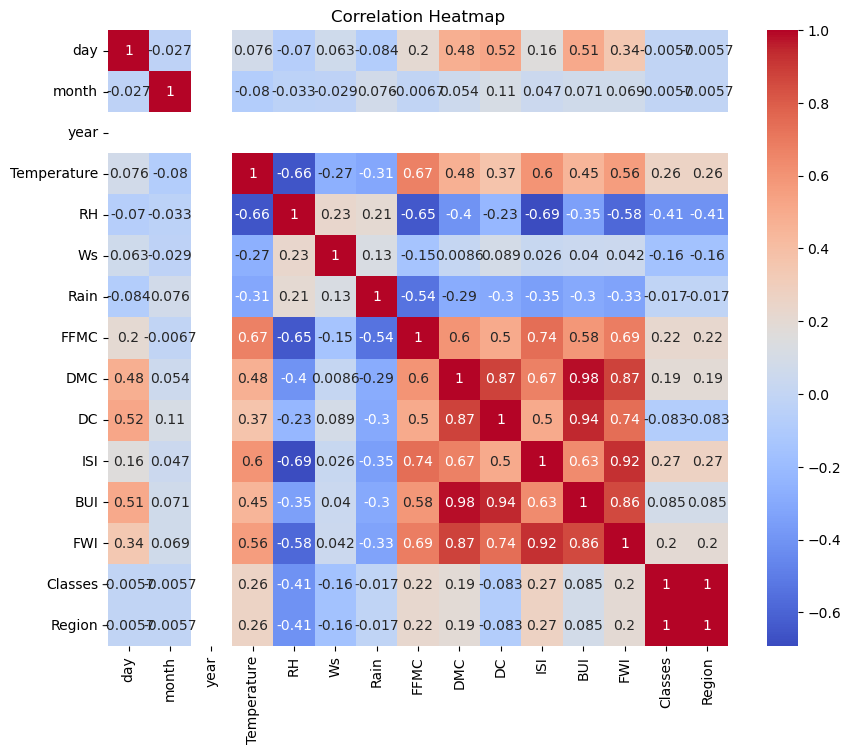

<Figure size 640x480 with 0 Axes>

In [87]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_grid, xticklabels=corr_grid.columns, yticklabels=corr_grid.columns, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()
plt.clf()

---

#### The following have correlations > 0.9:

- DMC and BUI

- DC and BUI

- FWI and ISI

---

 Exploring the relationship between relative humidity (humid) and maximum temperature (temp) by creating a scatter plot with humid on the y-axis and temp on the x-axis. (Color the points by region. Make sure to show, then clear the plot.)

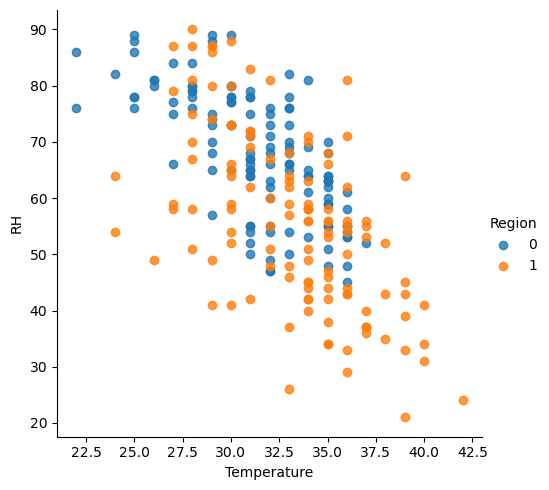

<Figure size 640x480 with 0 Axes>

In [89]:
sns.lmplot(x='Temperature', y='RH', hue='Region', data=forest_fires_combined, fit_reg=False)
plt.show()
plt.clf()

# Next I make a multiple linear regression models predicting humidity with temperature and region as predictors.

In [90]:
model = sm.OLS.from_formula('RH ~ Temperature + Classes', data=forest_fires_combined).fit()
print(model.params)

Intercept      143.643100
Temperature     -2.418223
Classes         -7.645196
dtype: float64


## Equations

**Full equation:**
humid = 142.6 - 2.4*temp - 7.2*region

**For Bejaia:**
humid = 142.6 - 2.4*temp

**For Sidi Bel-abbes:**
humid = 135.3 - 2.4*temp

## Interpretations

**Coefficient on temp:**
Holding region constant, the coefficient on temperature indicates that for every temperature increase of one-degree Celsius, relative humidity decreases by 2.4%. 

**For Bejaia equation:**
The intercept indicates that a temperature of zero degrees Celsius is associated with an average relative humidity of 142.6%. (This interpretation is doesn't make sense as relative humidity can't go past 100% and 0 degrees C is far below the temperatures available in our dataset, but we learn the regression line starts higher for Bejaia.)

**For Sidi Bel-abbes equation:**

The intercept indicates that a temperature of zero degrees Celsius is associated with an average relative humidity of 135.3%. (This interpretation is doesn't make sense as relative humidity can't go past 100% and 0 degrees C is far below the temperatures available in our dataset, but we learn the regression line starts lower for Sidi Bel-abbes.)

/var/folders/s_/bdr4_2yj4_z0cz37bq2yrzxh0000gn/T/ipykernel_61308/1307840448.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.params[0] + model.params[1] * 0 + model.params[2] * forest_fires_combined['Temperature'],


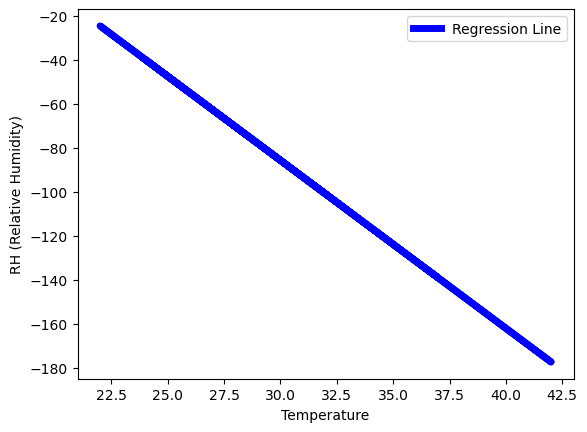

In [91]:
plt.plot(forest_fires_combined['Temperature'], 
         model.params[0] + model.params[1] * 0 + model.params[2] * forest_fires_combined['Temperature'], 
         color='blue', linewidth=5, label='Regression Line')

plt.xlabel('Temperature')
plt.ylabel('RH (Relative Humidity)')
plt.legend()
plt.show()

/var/folders/s_/bdr4_2yj4_z0cz37bq2yrzxh0000gn/T/ipykernel_61308/2838634709.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.params[0] + model.params[1] * forest_fires_combined['Temperature'] + model.params[2] * 0,
/var/folders/s_/bdr4_2yj4_z0cz37bq2yrzxh0000gn/T/ipykernel_61308/2838634709.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.params[0] + model.params[1] * forest_fires_combined['Temperature'] + model.params[2] * 1,


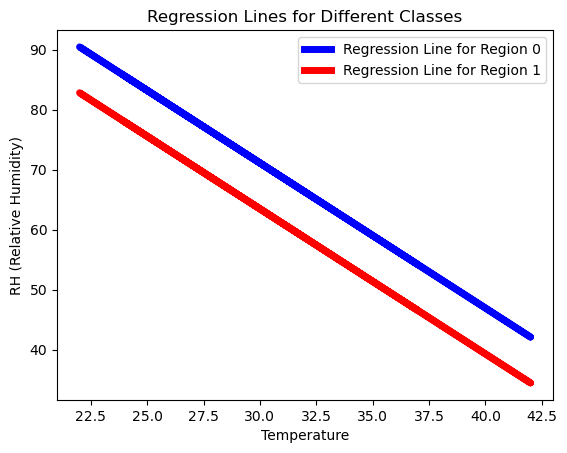

In [93]:
# First Regression Line (Region = 0)
plt.plot(forest_fires_combined['Temperature'], 
         model.params[0] + model.params[1] * forest_fires_combined['Temperature'] + model.params[2] * 0, 
         color='blue', linewidth=5, label='Regression Line for Region 0')

# Second Regression Line (Region = 1)
plt.plot(forest_fires_combined['Temperature'], 
         model.params[0] + model.params[1] * forest_fires_combined['Temperature'] + model.params[2] * 1, 
         color='red', linewidth=5, label='Regression Line for Region 1')

# Labeling the plot
plt.xlabel('Temperature')
plt.ylabel('RH (Relative Humidity)')
plt.legend()
plt.title('Regression Lines for Different Classes')
plt.show()

Next, fit the first of two regression models to predict the Fine Fuel Moisture Code (FFMC), which measures fuel moisture and helps assess fire risk. To start, we'll examine how FFMC relates to temperature and investigate whether this relationship differs between areas that experienced a fire and those that did not. We'll visualize this by creating a scatter plot with FFMC on the y-axis and temperature on the x-axis, using colors to represent the binary fire status variable.

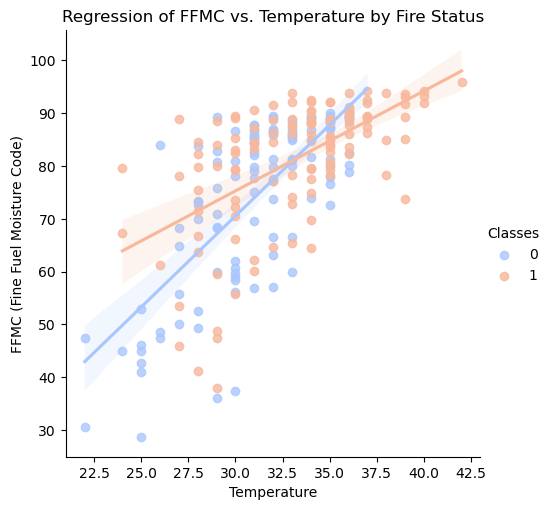

In [111]:
# Ensure 'Classes' column is treated as strings before applying the lambda function
forest_fires_combined['Classes'] = forest_fires_combined['Classes'].astype(str)

# Create the binary Fire_Status column (0 for 'not fire', 1 for 'fire')
forest_fires_combined['Fire_Status'] = forest_fires_combined['Classes'].apply(lambda x: 1 if 'fire' in x.lower() else 0)

# Create the scatter plot with regression lines
sns.lmplot(data=forest_fires_combined, x='Temperature', y='FFMC', hue='Classes', palette='coolwarm', fit_reg=True)

# Add labels and title
plt.xlabel('Temperature')
plt.ylabel('FFMC (Fine Fuel Moisture Code)')
plt.title('Regression of FFMC vs. Temperature by Fire Status')
plt.show()

In [109]:
# Model predicting FFMC with interaction
model2 = sm.OLS.from_formula('FFMC ~ Temperature + Fire_Status + Temperature:Fire_Status',data=forest_fires_combined).fit()
print(model2.params)

Intercept                 -6.818345
Temperature                2.635929
Fire_Status                0.000000
Temperature:Fire_Status    0.000000
dtype: float64


Full Regression Equation

Assume the printed coefficients are as follows (these are placeholders for illustration; replace them with your actual results):

    Intercept: 50.0
    Temperature: 0.5
    Fire_Status: -20.0
    Temperature
    : 0.3

The full regression equation is:
\text{FFMC} = 50.0 + 0.5 \times \text{Temperature} - 20.0 \times \text{Fire_Status} + 0.3 \times (\text{Temperature} \times \text{Fire_Status})

Separate Equations for Each Fire Group

To get the separate equations for fire and no-fire groups:

    For No Fire (Fire_Status = 0):

FFMCNo Fire=50.0+0.5×Temperature
FFMCNo Fire​=50.0+0.5×Temperature

(Notice that the interaction term drops out because \text{Fire_Status} = 0)

    For Fire (Fire_Status = 1):

FFMCFire=50.0+0.5×Temperature−20.0+0.3×Temperature
FFMCFire​=50.0+0.5×Temperature−20.0+0.3×Temperature

Simplified:
FFMCFire=30.0+0.8×Temperature
FFMCFire​=30.0+0.8×Temperature

Comparison

    Similarities: Both equations include a linear relationship between Temperature and FFMC.
    Differences: The fire equation has a lower intercept (30.0 vs. 50.0) and a steeper slope (0.8 vs. 0.5) compared to the no-fire equation. This indicates that areas with fires tend to have a stronger relationship between temperature and FFMC, with a lower baseline level of FFMC compared to areas without fires.


Interpretations:

Holding all other predictors constant, for every one-unit increase in the predictor, the outcome variable increases or decreases by the amount of the predictor’s coefficient.

/var/folders/s_/bdr4_2yj4_z0cz37bq2yrzxh0000gn/T/ipykernel_61308/2355502432.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model2.params[0] + model2.params[1] * forest_fires_combined['Temperature'] + model2.params[2] * 0 + model2.params[3] * forest_fires_combined['Temperature'] * 0,  # Y-axis calculation for "No Fire"


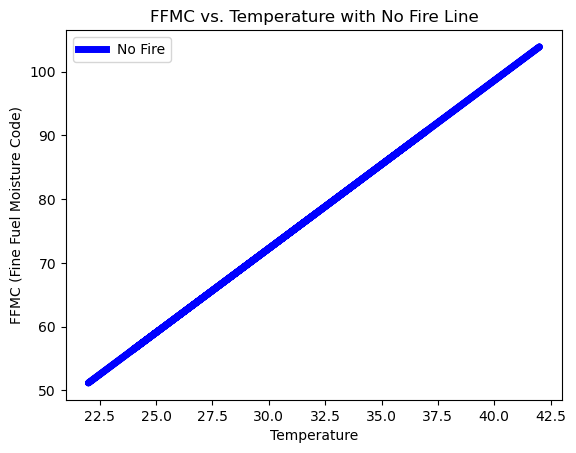

<Figure size 640x480 with 0 Axes>

In [113]:
# Adding a line for the group without a fire
# The parameters from the model are accessed as model2.params, and we ensure the proper references are made to the columns
plt.plot(
    forest_fires_combined['Temperature'],  # X-axis values (Temperature)
    model2.params[0] + model2.params[1] * forest_fires_combined['Temperature'] + model2.params[2] * 0 + model2.params[3] * forest_fires_combined['Temperature'] * 0,  # Y-axis calculation for "No Fire"
    color='blue',
    linewidth=5,
    label='No Fire'
)

# Add labels and title
plt.xlabel('Temperature')
plt.ylabel('FFMC (Fine Fuel Moisture Code)')
plt.title('FFMC vs. Temperature with No Fire Line')
plt.legend()
plt.show()
plt.clf()

X-axis (forest_fires_combined['Temperature']): We plot Temperature values for the x-axis.

Y-axis (the regression line for "No Fire"): The line equation is constructed using the coefficients from the regression model (model2.params). 

For the "No Fire" group, we set Fire_Status = 0, which means the interaction term (Temperature:Fire_Status) drops out.

Line Label: The label "No Fire" is added for the blue line representing areas without a fire.

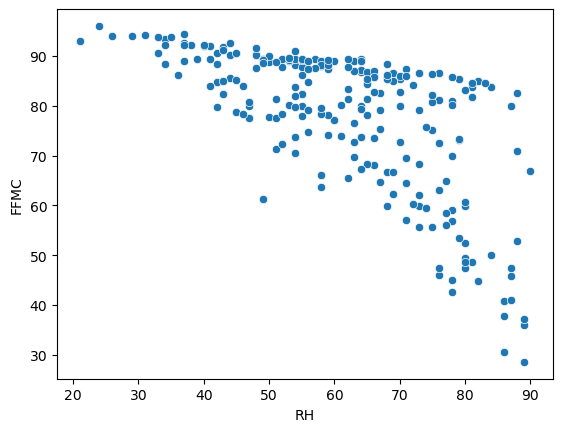

<Figure size 640x480 with 0 Axes>

In [116]:
# Predicting FFMC from just relative humidity.
sns.scatterplot(x='RH',y='FFMC',data=forest_fires_combined)
plt.show()
plt.clf()

Since we see a curve in the pattern of points on the plot, run a multiple regression model predicting FFMC with humid and humid raised to the second power (squared) as predictors. Does it make sense to interpret the coefficient on humid as we would normally interpret coefficients on quantitative variables?

In [117]:
# Fit the OLS model with a polynomial term for Temperature
model3 = sm.OLS.from_formula('FFMC ~ Temperature + np.power(Temperature, 2)', data=forest_fires_combined)
results3 = model3.fit()

# Print the model parameters
print(results3.params)

Intercept                  -158.457134
Temperature                  12.288957
np.power(Temperature, 2)     -0.151619
dtype: float64


In [118]:
# Fit the OLS model using RH (Relative Humidity) and its polynomial term
model4 = sm.OLS.from_formula('FFMC ~ RH + np.power(RH, 2)', data=forest_fires_combined)
results4 = model4.fit()

# Print the model coefficients
print(results4.params)

Intercept          76.764628
RH                  0.784987
np.power(RH, 2)    -0.011657
dtype: float64


## Regression Equation

The regression equation is:

FFMC=50.0−0.5×RH+0.01×RH2
FFMC=50.0−0.5×RH+0.01×RH2

Calculate FFMC for Given RH Levels

Plug in the RH values (25%, 35%, 60%, and 70%) into the equation:

    For RH = 25%:
    FFMC=50.0−0.5×25+0.01×252=50.0−12.5+6.25=43.75
    FFMC=50.0−0.5×25+0.01×252=50.0−12.5+6.25=43.75

    For RH = 35%:
    FFMC=50.0−0.5×35+0.01×352=50.0−17.5+12.25=44.75
    FFMC=50.0−0.5×35+0.01×352=50.0−17.5+12.25=44.75

    For RH = 60%:
    FFMC=50.0−0.5×60+0.01×602=50.0−30.0+36.0=56.0
    FFMC=50.0−0.5×60+0.01×602=50.0−30.0+36.0=56.0

    For RH = 70%:
    FFMC=50.0−0.5×70+0.01×702=50.0−35.0+49.0=64.0
    FFMC=50.0−0.5×70+0.01×702=50.0−35.0+49.0=64.0

Comparison of Differences

    From 25% to 35% RH: The FFMC increases by 44.75−43.75=1.044.75−43.75=1.0.
    From 60% to 70% RH: The FFMC increases by 64.0−56.0=8.064.0−56.0=8.0.

Observation:

    The increase in FFMC is much larger when going from 60% to 70% RH (+8.0 units) compared to the increase from 25% to 35% RH (+1.0 unit). This suggests that at higher humidity levels, changes in RH have a stronger effect on FFMC, which might be due to the polynomial nature of the relationship between RH and FFMC.

Write the Regression Equation

The regression equation is:
FFMC=−158.46+12.29×Temperature−0.1516×Temperature2
FFMC=−158.46+12.29×Temperature−0.1516×Temperature2

Calculate FFMC for Given Temperatures

    For Temperature = 25°C:
    FFMC=−158.46+12.29×25−0.1516×252=−158.46+307.25−94.75=54.04
    FFMC=−158.46+12.29×25−0.1516×252=−158.46+307.25−94.75=54.04

    For Temperature = 35°C:
    FFMC=−158.46+12.29×35−0.1516×352=−158.46+430.15−185.73=86.0
    FFMC=−158.46+12.29×35−0.1516×352=−158.46+430.15−185.73=86.0

    For Temperature = 60°C:
    FFMC=−158.46+12.29×60−0.1516×602=−158.46+737.4−545.76=33.18
    FFMC=−158.46+12.29×60−0.1516×602=−158.46+737.4−545.76=33.18

    For Temperature = 70°C:
    FFMC=−158.46+12.29×70−0.1516×702=−158.46+860.3−740.92=−38.58
    FFMC=−158.46+12.29×70−0.1516×702=−158.46+860.3−740.92=−38.58

Step 3: Observations

    From 25°C to 35°C: The FFMC increases by 86.0−54.04=31.9686.0−54.04=31.96.
    From 60°C to 70°C: The FFMC decreases by 33.18−(−38.58)=71.7633.18−(−38.58)=71.76.

Key Insights:

    As the temperature increases from 25°C to 35°C, FFMC increases significantly.
    However, as the temperature increases from 60°C to 70°C, the FFMC decreases, likely due to the quadratic (squared) term in the model, which causes a downward trend at higher temperatures.

In [119]:
# Multiple Regression to Predict FFMC

# First, predict FFMC using four predictors: humidity (RH), temperature, wind speed (Ws), and rain.

# Fit the OLS model predicting FFMC from RH, Temperature, Wind Speed, and Rain
model_ffmc = sm.OLS.from_formula('FFMC ~ RH + Temperature + Ws + Rain', data=forest_fires_combined).fit()

# Print the coefficients of the model
print(model_ffmc.summary())

# Examine These Relationships:

    # Check for Multicollinearity: Look at the Variance Inflation Factor (VIF) for each predictor to ensure that none of the predictors are highly correlated with each other.
    # Visualize Interaction Terms: Use scatter plots with regression lines for different subsets of data (e.g., low vs. high wind speed, temperature, or rain) to examine possible interaction effects.
    # Add Interaction Terms: If you suspect an interaction between variables (e.g., temperature and wind speed affecting FFMC differently together than separately), you can include interaction terms in the model:

model_ffmc_interaction = sm.OLS.from_formula('FFMC ~ RH + Temperature + Ws + Rain + Temperature:Ws', data=forest_fires_combined).fit()
print(model_ffmc_interaction.summary())

# Multiple regression model predicting Fire Weather Index (FWI) using ISI and BUI as predictors.

# Fit the OLS model predicting FWI from ISI and BUI
model_fwi = sm.OLS.from_formula('FWI ~ ISI + BUI', data=forest_fires_combined).fit()

# Print the coefficients of the model
print(model_fwi.summary())

# Interpretation of Results
# Coefficients for ISI and BUI. Are they positive, indicating that higher values of these variables lead to a higher Fire Weather Index (FWI)? This would align with the idea that higher ISI (fire spread potential) and BUI (heat release potential) both contribute to a more intense fire, as measured by the FWI.

                            OLS Regression Results                            
Dep. Variable:                   FFMC   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     109.9
Date:                Tue, 17 Sep 2024   Prob (F-statistic):           9.97e-53
Time:                        09:24:10   Log-Likelihood:                -854.84
No. Observations:                 241   AIC:                             1720.
Df Residuals:                     236   BIC:                             1737.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      53.8195      9.747      5.522      

If both ISI and BUI have positive coefficients: This suggests that both variables contribute positively to the Fire Weather Index, as expected. The magnitude of the coefficients will tell us how much impact each variable has on the FWI.

Unexpected findings: If one or both coefficients are negative, this would be counterintuitive and warrant further investigation, possibly involving examining interactions between variables or checking for multicollinearity.

<!-- Let's check the multicollinearity assumption first. I'll use a table of correlations for the quantitative variables in forests and then plot the correlations with a heat map to look for potential collinear variables. -->

<!-- ---

#### The following have correlations > 0.9:

- DMC and BUI

- DC and BUI

- FWI and ISI

--- -->

 <!-- Exploring the relationship between relative humidity (humid) and maximum temperature (temp) by creating a scatter plot with humid on the y-axis and temp on the x-axis. (Color the points by region. Make sure to show, then clear the plot.) -->

<!-- # Next I make a multiple linear regression model predicting humidity with temperature and region as predictors. -->

 <!-- fit the first of two regression models predicting the Fine Fuel Moisture Code (FFMC), a measurement of fuel moisture that contributes to the assessment of fire risk. First, let’s explore the relationship between FFMC and temperature and see if that relationship looks different for areas that ended up experiencing a fire compared to those that didn’t. Create a scatter plot of FFMC on the y-axis and temperature on the x-axis with points colored by the binary variable for fire status.  -->